# Alzheimer’s Disease Classification from Brain MRI (4-Class) — End-to-End CNN (TensorFlow/Keras)

This notebook is an **updated, presentation-ready** version of your previous training notebook, adapted for an **Alzheimer MRI 4-class classification** project.

## What you will do
1. Set up imports + reproducibility
2. Load and validate dataset folder structure
3. Preprocess MRI images (MRI-friendly)
4. Build a strong CNN using **transfer learning (DenseNet121)**
5. Train with callbacks + (optional) class weights
6. Evaluate with accuracy, classification report, and confusion matrix
7. Save the final model + run quick inference on a sample image

> **Note (medical disclaimer):** This is an educational ML project, **not** a medical diagnostic system.

In [1]:
# =========================
# 1) Imports + Setup
# =========================
import os
import random
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

print("TensorFlow:", tf.__version__)

TensorFlow: 2.10.1


## Reproducibility (recommended)
Deep learning is not perfectly deterministic on all hardware, but setting seeds makes results **more repeatable**.

In [2]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: makes some TF ops more deterministic (may reduce speed on GPU)
# tf.config.experimental.enable_op_determinism()

# 2) Dataset: Expected folder structure

Most Alzheimer MRI datasets are organized like:

```
dataset/
  train/
    NonDemented/
    VeryMildDemented/
    MildDemented/
    ModerateDemented/
  test/   (optional)
    ...
```

If your dataset only has a single folder (no train/test split), this notebook will create a **stratified split** for train/val/test automatically.

In [3]:
# =========================
# 2) Configure your dataset path here (FINAL WORKING CELL)
# =========================

import os
import zipfile

DATA_ROOT = "dataset"
ZIP_PATH = "Alzheimer_MRI_4_classes_dataset.zip"

os.makedirs(DATA_ROOT, exist_ok=True)

# Extract zip
if os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(DATA_ROOT)
    print("ZIP extracted successfully.")

# Dataset is inside nested folder
train_dir = os.path.join(DATA_ROOT, "Alzheimer_MRI_4_classes_dataset")
test_dir = None

# Detect real class folders
class_names = sorted([
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
])

print("Using train_dir:", train_dir)
print("Detected classes:", class_names)


ZIP extracted successfully.
Using train_dir: dataset\Alzheimer_MRI_4_classes_dataset
Detected classes: ['.ipynb_checkpoints', 'MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


## Detect classes
We infer classes from subfolder names inside the training folder.  
If no training folder exists, we will infer classes from `DATA_ROOT` directly (single-folder dataset).

In [4]:
def list_class_folders(root_dir: str):
    return sorted([
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith(".")
    ])

if train_dir is None:
    # Single-folder dataset fallback:
    # DATA_ROOT contains the class folders directly
    if os.path.isdir(DATA_ROOT) and len(list_class_folders(DATA_ROOT)) > 0:
        train_dir = DATA_ROOT
        print("Using single-folder dataset at:", train_dir)
    else:
        raise FileNotFoundError(
            "Could not find a training folder. Please set DATA_ROOT to your dataset directory."
        )

class_names = list_class_folders(train_dir)
NUM_CLASSES = len(class_names)

print("Classes:", class_names)
print("NUM_CLASSES:", NUM_CLASSES)

assert NUM_CLASSES >= 2, "Need at least 2 class folders."

Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CLASSES: 4


# 3) Build an index of all images
We scan the dataset folders and build a dataframe of:

- `filepath`
- `label` (class name)
- `label_id` (numeric)

This makes splitting and debugging easier.

In [5]:
IMAGE_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

def build_file_index(root_dir: str):
    rows = []
    classes = list_class_folders(root_dir)
    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(IMAGE_EXTS):
                rows.append({"filepath": os.path.join(cls_dir, fname), "label": cls})
    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError(f"No images found under: {root_dir}")
    df["label_id"] = df["label"].map({c:i for i,c in enumerate(classes)})
    return df, classes

df_all, classes_found = build_file_index(train_dir)
print(df_all.head())
print(df_all["label"].value_counts())

                                            filepath         label  label_id
0  dataset\Alzheimer_MRI_4_classes_dataset\MildDe...  MildDemented         0
1  dataset\Alzheimer_MRI_4_classes_dataset\MildDe...  MildDemented         0
2  dataset\Alzheimer_MRI_4_classes_dataset\MildDe...  MildDemented         0
3  dataset\Alzheimer_MRI_4_classes_dataset\MildDe...  MildDemented         0
4  dataset\Alzheimer_MRI_4_classes_dataset\MildDe...  MildDemented         0
label
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64


# 4) Train/Validation/Test split (stratified)

- If you already have a separate `test/` folder, we use it as test set.
- Otherwise, we split from the same pool:
  - Train: 70%
  - Val:   15%
  - Test:  15%

Stratified splitting keeps class proportions similar across splits.

In [6]:
VAL_SIZE = 0.15
TEST_SIZE = 0.15  # used only when no external test_dir is found

if test_dir is not None:
    df_test, _ = build_file_index(test_dir)
    df_trainval = df_all.copy()

    df_train, df_val = train_test_split(
        df_trainval,
        test_size=VAL_SIZE,
        random_state=SEED,
        stratify=df_trainval["label_id"]
    )
else:
    df_train, df_temp = train_test_split(
        df_all,
        test_size=VAL_SIZE + TEST_SIZE,
        random_state=SEED,
        stratify=df_all["label_id"]
    )
    relative_val = VAL_SIZE / (VAL_SIZE + TEST_SIZE)
    df_val, df_test = train_test_split(
        df_temp,
        test_size=1 - relative_val,
        random_state=SEED,
        stratify=df_temp["label_id"]
    )

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))
print("Train label counts:\n", df_train["label"].value_counts())

Train: 4480 Val: 960 Test: 960
Train label counts:
 label
NonDemented         2240
VeryMildDemented    1568
MildDemented         627
ModerateDemented      45
Name: count, dtype: int64


# 5) MRI-friendly preprocessing

### Why we avoid aggressive contour-cropping here
Your earlier brain-tumor notebook used contour-based cropping (Otsu threshold).  
For Alzheimer staging, **subtle structure patterns** matter, and aggressive cropping can:

- cut out important regions
- behave inconsistently across slices

### We will do
- Read image with OpenCV
- Convert to grayscale (MRI is typically grayscale)
- Resize to model size (224×224)
- Normalize later using model-specific preprocessing

> If you still want cropping, use *center crop* (safe + consistent), not threshold-based crop.

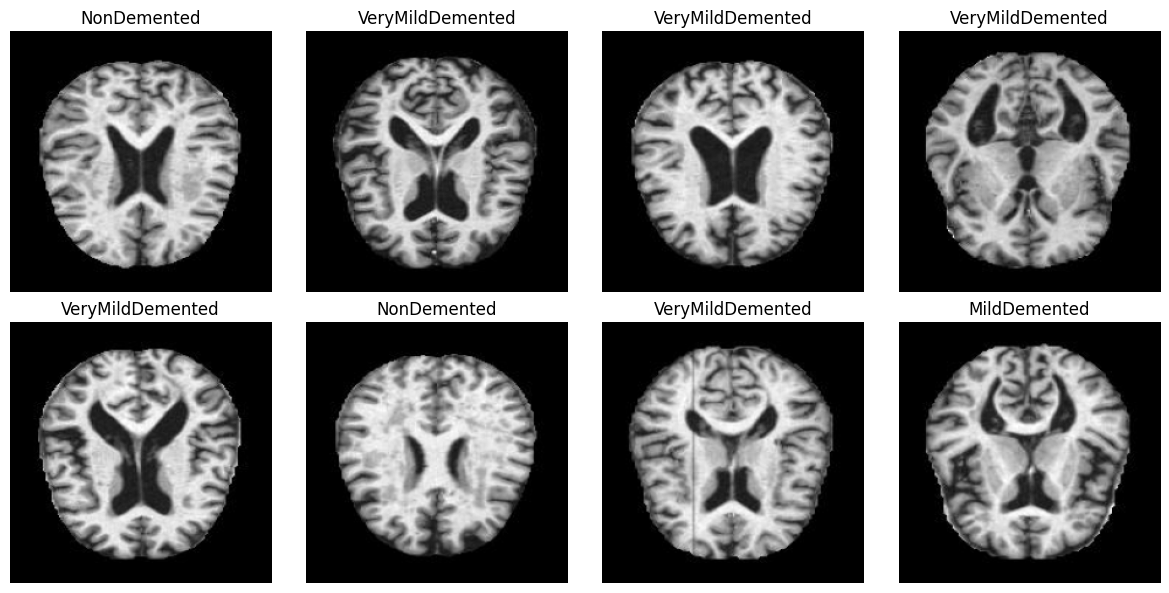

In [7]:
IMG_SIZE = (224, 224)

def read_mri_image(path: str, img_size=IMG_SIZE):
    # Read
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to read image: {path}")

    # Resize
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

    # Convert to 3-channel (so ImageNet CNNs can be used)
    img = np.stack([img, img, img], axis=-1)  # (H, W, 3)
    return img

# Visualize a few samples
sample_paths = df_train.sample(n=min(8, len(df_train)), random_state=SEED)["filepath"].tolist()
plt.figure(figsize=(12, 6))
for i, p in enumerate(sample_paths):
    img = read_mri_image(p)
    plt.subplot(2, 4, i+1)
    plt.imshow(img[:, :, 0], cmap="gray")
    plt.title(os.path.basename(os.path.dirname(p)))
    plt.axis("off")
plt.tight_layout()
plt.show()

# 6) Create NumPy datasets (simple approach)

This approach loads images into memory (RAM).  
If your dataset is huge, switch to `tf.data` pipelines — but for most Kaggle Alzheimer datasets, this is fine.

We will create:
- `X_train, y_train`
- `X_val, y_val`
- `X_test, y_test`

In [8]:
def load_split(df: pd.DataFrame):
    X = np.zeros((len(df), IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    y = df["label_id"].values.astype(np.int32)
    for i, path in enumerate(df["filepath"].values):
        X[i] = read_mri_image(path)
    return X, y

X_train_raw, y_train = load_split(df_train.reset_index(drop=True))
X_val_raw,   y_val   = load_split(df_val.reset_index(drop=True))
X_test_raw,  y_test  = load_split(df_test.reset_index(drop=True))

print("X_train:", X_train_raw.shape, "y_train:", y_train.shape)
print("X_val  :", X_val_raw.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test_raw.shape,  "y_test :", y_test.shape)

X_train: (4480, 224, 224, 3) y_train: (4480,)
X_val  : (960, 224, 224, 3) y_val  : (960,)
X_test : (960, 224, 224, 3) y_test : (960,)


## One-hot encode labels
Keras softmax classifier expects one-hot labels for `categorical_crossentropy`.

In [9]:
y_train_oh = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val_oh   = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test_oh  = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

y_train_oh.shape, y_val_oh.shape, y_test_oh.shape

((4480, 4), (960, 4), (960, 4))

# 7) Data augmentation (MRI-safe)

We use **small** augmentations:
- slight rotation
- slight shift
- slight zoom

We avoid strong color transforms (MRI is grayscale), and we keep flips disabled by default.

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05
)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train_raw, y_train_oh, batch_size=32, shuffle=True, seed=SEED)
val_gen   = val_datagen.flow(X_val_raw, y_val_oh, batch_size=32, shuffle=False)

# 8) Model: Recommended CNN for this project (Edge / Vitis-friendly)

## Recommended: **MobileNetV2 (ImageNet pretrained)**
For deployment on **PYNQ + Vitis AI (.xmodel)**, MobileNetV2 is a strong choice:
- **Lightweight** (faster inference, smaller memory)
- **DPU-friendly** (quantization + compilation is usually smoother)
- Still provides good accuracy for 4-class classification

Training strategy:
1. **Freeze** the pretrained backbone and train the new classification head
2. **Fine-tune** the top layers with a smaller learning rate


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

NUM_CLASSES = len(class_names)  # should be 4

# Build backbone (ImageNet pretrained)
base_model = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)
base_model.trainable = False  # Phase 1: train head only

# Build full model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)              # IMPORTANT: MobileNetV2 preprocessing (-1..1)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

## Compile the model
We use:
- Adam optimizer
- categorical cross entropy
- accuracy metric

For imbalanced datasets, also compute **class weights** (optional but recommended).

In [12]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Optional: class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 1.7862838915470494, 1: 24.88888888888889, 2: 0.5, 3: 0.7142857142857143}


# 9) Callbacks (training stability + best model saving)

- **EarlyStopping**: stop if validation stops improving
- **ReduceLROnPlateau**: lower LR when val loss plateaus
- **ModelCheckpoint**: always save the best model

In [13]:
CHECKPOINT_PATH = "best_alzheimer_mobilenetv2.keras"

callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint(CHECKPOINT_PATH, monitor="val_loss", save_best_only=True)
]

# 10) Train (Phase 1): Train only the classification head

In [14]:
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weight_dict  # remove if you don't want class weighting
)

Epoch 1/20
140/140 [==============================] - 65s 346ms/step - loss: 1.5711 - accuracy: 0.2317 - val_loss: 1.2730 - val_accuracy: 0.3677 - lr: 1.0000e-04
Epoch 2/20
140/140 [==============================] - 43s 310ms/step - loss: 1.4989 - accuracy: 0.2888 - val_loss: 1.2567 - val_accuracy: 0.4042 - lr: 1.0000e-04
Epoch 3/20
140/140 [==============================] - 45s 322ms/step - loss: 1.4181 - accuracy: 0.3219 - val_loss: 1.1747 - val_accuracy: 0.4833 - lr: 1.0000e-04
Epoch 4/20
140/140 [==============================] - 41s 288ms/step - loss: 1.3942 - accuracy: 0.3373 - val_loss: 1.2219 - val_accuracy: 0.4552 - lr: 1.0000e-04
Epoch 5/20
140/140 [==============================] - 41s 289ms/step - loss: 1.3424 - accuracy: 0.3627 - val_loss: 1.1786 - val_accuracy: 0.4781 - lr: 1.0000e-04
Epoch 6/20
140/140 [==============================] - 45s 317ms/step - loss: 1.3241 - accuracy: 0.3571 - val_loss: 1.1112 - val_accuracy: 0.5104 - lr: 1.0000e-04
Epoch 7/20
140/140 [========

## Plot training curves

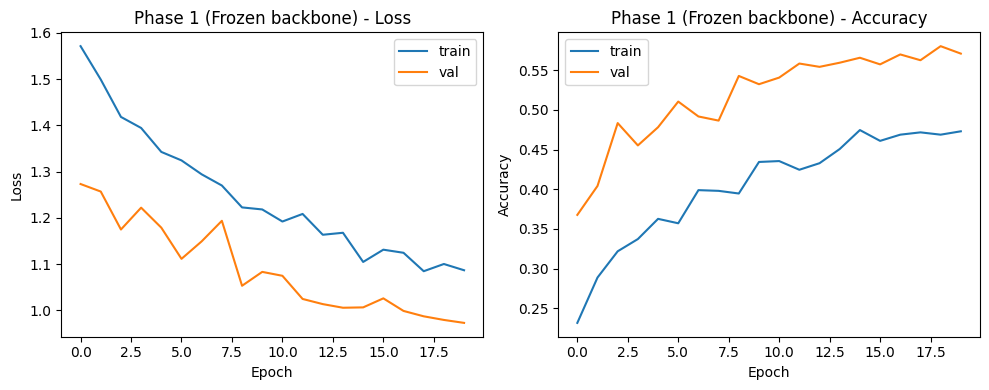

In [15]:
def plot_history(hist, title="Training Curves"):
    plt.figure(figsize=(10,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"], label="train")
    plt.plot(hist.history["val_loss"], label="val")
    plt.title(title + " - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(hist.history["accuracy"], label="train")
    plt.plot(hist.history["val_accuracy"], label="val")
    plt.title(title + " - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history1, "Phase 1 (Frozen backbone)")

# 11) Fine-tuning (Phase 2): Unfreeze top layers (optional but recommended)

We unfreeze the backbone and keep the bottom layers frozen.  
This improves accuracy by adapting the pretrained features to MRI data.

**Important:** use a smaller learning rate for fine-tuning.

Epoch 1/10
140/140 [==============================] - 55s 360ms/step - loss: 1.0282 - accuracy: 0.4973 - val_loss: 0.9326 - val_accuracy: 0.5833 - lr: 1.0000e-05
Epoch 2/10
140/140 [==============================] - 58s 412ms/step - loss: 0.9127 - accuracy: 0.5259 - val_loss: 0.8770 - val_accuracy: 0.5958 - lr: 1.0000e-05
Epoch 3/10
140/140 [==============================] - 56s 401ms/step - loss: 0.8854 - accuracy: 0.5583 - val_loss: 0.8461 - val_accuracy: 0.6052 - lr: 1.0000e-05
Epoch 4/10
140/140 [==============================] - 55s 389ms/step - loss: 0.8170 - accuracy: 0.5571 - val_loss: 0.8189 - val_accuracy: 0.6344 - lr: 1.0000e-05
Epoch 5/10
140/140 [==============================] - 51s 365ms/step - loss: 0.7846 - accuracy: 0.5746 - val_loss: 0.7842 - val_accuracy: 0.6500 - lr: 1.0000e-05
Epoch 6/10
140/140 [==============================] - 51s 363ms/step - loss: 0.7187 - accuracy: 0.5850 - val_loss: 0.8633 - val_accuracy: 0.5917 - lr: 1.0000e-05
Epoch 7/10
140/140 [========

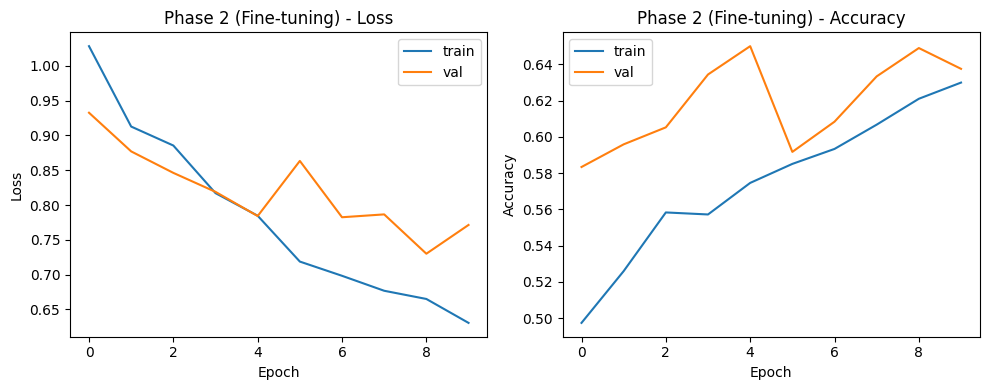

In [16]:
# Unfreeze the base model
base_model.trainable = True

# Freeze earlier layers to avoid destroying pretrained features
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

plot_history(history2, "Phase 2 (Fine-tuning)")

# 12) Evaluation on the test set

We report:
- Test accuracy
- Classification report (precision/recall/F1 per class)
- Confusion matrix (visual)

Test Loss: 0.7573
Test Accuracy: 0.6490

Classification Report:
                  precision    recall  f1-score   support

    MildDemented     0.4891    0.4963    0.4926       135
ModerateDemented     1.0000    0.6667    0.8000         9
     NonDemented     0.7159    0.7875    0.7500       480
VeryMildDemented     0.5952    0.5119    0.5504       336

        accuracy                         0.6490       960
       macro avg     0.7000    0.6156    0.6483       960
    weighted avg     0.6444    0.6490    0.6444       960

Confusion Matrix:
 [[ 67   0  23  45]
 [  1   6   0   2]
 [ 32   0 378  70]
 [ 37   0 127 172]]


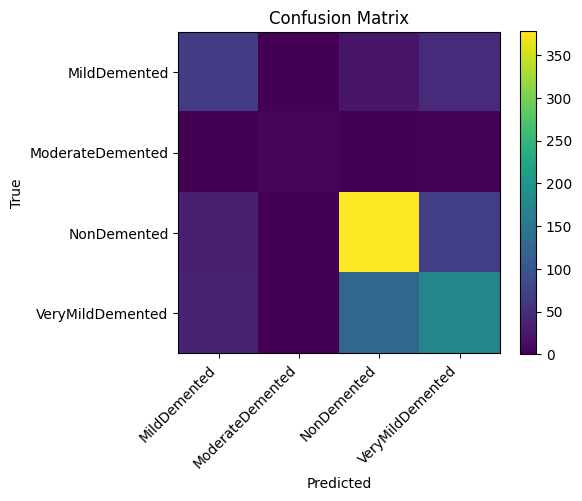

In [17]:
# Load best model (ensures we evaluate the best checkpoint)
best_model = tf.keras.models.load_model(CHECKPOINT_PATH)

test_loss, test_acc = best_model.evaluate(X_test_raw, y_test_oh, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_prob = best_model.predict(X_test_raw, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(NUM_CLASSES), class_names, rotation=45, ha="right")
plt.yticks(range(NUM_CLASSES), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

# 13) Save final model + quick inference

We save:
- Best checkpoint (already saved by callback)
- An additional final export (optional)

Then we run inference on a single image.

In [18]:
FINAL_EXPORT_PATH = "alzheimer_mobilenetv2_final.keras"
best_model.save(FINAL_EXPORT_PATH)
print("Saved final model to:", FINAL_EXPORT_PATH)

Saved final model to: alzheimer_mobilenetv2_final.keras


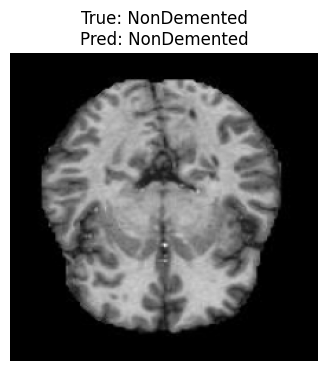

Predicted probabilities:
MildDemented        : 0.0340
ModerateDemented    : 0.0026
NonDemented         : 0.8042
VeryMildDemented    : 0.1592


In [19]:
# Quick inference on a single test image
idx = 0
img = X_test_raw[idx]
true_label = class_names[y_test[idx]]

pred_probs = best_model.predict(img[None, ...], verbose=0)[0]
pred_id = int(np.argmax(pred_probs))
pred_label = class_names[pred_id]

plt.figure(figsize=(4,4))
plt.imshow(img[:, :, 0], cmap="gray")
plt.title(f"True: {true_label}\nPred: {pred_label}")
plt.axis("off")
plt.show()

print("Predicted probabilities:")
for c, p in zip(class_names, pred_probs):
    print(f"{c:20s}: {p:.4f}")

In [24]:
import os
import shutil
import tensorflow as tf

SAVEDMODEL_DIR = "saved_model_keras"

# Remove old folder if exists
if os.path.exists(SAVEDMODEL_DIR):
    shutil.rmtree(SAVEDMODEL_DIR)

# Export SavedModel (Vitis AI compatible)
tf.saved_model.save(best_model, SAVEDMODEL_DIR)

print("SavedModel exported to:", SAVEDMODEL_DIR)
print("Contents:", os.listdir(SAVEDMODEL_DIR))


INFO:tensorflow:Assets written to: saved_model_keras\assets


INFO:tensorflow:Assets written to: saved_model_keras\assets


SavedModel exported to: saved_model_keras
Contents: ['assets', 'saved_model.pb', 'variables']


In [25]:
import os, shutil, tensorflow as tf

# Load your trained model (use your actual filename)
m = tf.keras.models.load_model("alzheimer_mobilenetv2_final.keras")

EXPORT_DIR = "saved_model_keras_vitis"

# Remove old folder if exists
if os.path.exists(EXPORT_DIR):
    shutil.rmtree(EXPORT_DIR)

# IMPORTANT: this produces keras_metadata.pb
m.save(EXPORT_DIR, save_format="tf")

print("Exported to:", EXPORT_DIR)
print("Files:", os.listdir(EXPORT_DIR))


INFO:tensorflow:Assets written to: saved_model_keras_vitis\assets


INFO:tensorflow:Assets written to: saved_model_keras_vitis\assets


Exported to: saved_model_keras_vitis
Files: ['assets', 'keras_metadata.pb', 'saved_model.pb', 'variables']


# 14) Next steps to make this project “portfolio-ready”

✅ Add these to your GitHub repo:
- `README.md` with problem statement + dataset + results + how to run
- `requirements.txt` or `environment.yml`
- confusion matrix image + training curves
- `Streamlit` demo (optional but very impressive)
- a `model_card.md` explaining limitations & ethics

If you want, I can also convert this into a **clean repo structure**:
`src/`, `scripts/train.py`, `configs/train.yaml`, etc.